In [1]:
import os
os.chdir('../')

In [2]:
%matplotlib inline
#%matplotlib notebook

%load_ext autoreload
%autoreload 2

In [3]:
from copy import deepcopy
from typing import List, Tuple

from cycler import cycler
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import numpy as np
import pandas as pd
import scipy.sparse as sp
from sklearn.decomposition import PCA
import scipy.stats as stats
import torch
from torch import nn
import torch.nn.functional as F
import seml

import tqdm
tqdm.tqdm.pandas()
#plt.style.use('ggplot')

/nfs/homedirs/schmidtt/miniconda3/lib/python3.8/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [4]:
from notebooks import mpl_latex

/nfs/homedirs/schmidtt/miniconda3/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


In [5]:
#mpl_latex.enable_production_mode()

In [6]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

In [7]:
labels_to_plot = [
    'Vanilla GCN',
    'Vanilla GDC',
    'SVD GCN',
    'Jaccard GCN',
    'RGCN',
    'Soft Medoid GDC (T=0.5)',
    #'Soft Median GDC (T=1.0)',
    #'Soft Median GDC (T=0.5)',
    'Soft Median GDC (T=0.2)',
    'Soft Median GDC (T=5.0)',
    'Vanilla PPRGo',
    'Soft Medoid RPPRGo (T=0.5)',
    'Soft Median RPPRGo (T=0.5)'
]

In [8]:
dataset_map = {
    'cora_ml': r'\textbf{Cora ML}',#'~\citep{Bojchevski2018}}', # '\rotatebox{90}{Cora ML~\citep{Bojchevski2018}}',
    'citeseer': r'\textbf{Citeseer}',#~\citep{McCallum2000}}',
    'pubmed': r'\textbf{PubMed}',#~\citep{Sen2008}}',
    'ogbn-arxiv': r'\textbf{arXiv}',#~\citep{Hu2020}}',
    'ogbn-products': r'\textbf{Products}',#~\citep{Hu2020}}',
    'ogbn-papers100M': r'\textbf{Papers 100M}',#~\citep{Hu2020}}'
}
dataset_order = [dataset_map[k] for k in dataset_map.keys()]

In [9]:
attack_map = {
    'DICE': r'\textbf{DICE}',
    #'GANG': r'\textbf{GANG (ours)}',
    'FGSM': r'\textbf{greedy FGSM}',
    'GreedyRBCD': r'\textbf{GR-BCD (ours)}',
    'PGD': r'\textbf{PGD}',
    'PRBCD': r'\textbf{PR-BCD (ours)}'
}
attack_order = [attack_map[k] for k in attack_map.keys()]

In [10]:
pm = r'\(\pm\)'
bpm = r'\(\boldsymbol{\pm}\)'

In [11]:
def make_max_bold(group):
    for col in list(group.columns):
        if not group[col].isna().all():
            idx = np.where(np.max(group[col].fillna("")) == group[col].fillna(""))[0]
            group.loc[group.index[idx], col] = rf'\textbf{{{group.loc[group.index[idx], col].iloc[0]}}}'\
                .replace(pm, bpm)
    return group

In [12]:
def make_second_best_underlined(group):
    for col in list(group.columns):
        if not group[col].isna().all() and np.unique(group[col].fillna("")).shape[0] > 1:
            second_max = np.unique(group[col].fillna("").apply(
                lambda v: v.replace(r'\textbf{', '').replace('}', '')
            ))[-2]
            idx = np.where(second_max == group[col].fillna(""))[0]
            group.loc[group.index[idx], col] = rf'\underline{{{group.loc[group.index[idx], col].iloc[0]}}}'
    return group

In [13]:
def mark_best_and_second_best(group: pd.DataFrame, 
                              first_mark: str = r'\textbf',
                              second_mark: str = r'\underline',
                              dimension: int = 0) -> pd.DataFrame:
    iterable  

In [14]:
def calc_mean_and_error(values: pd.Series, seeds: pd.Series, with_error=True, decimal_places: int = 3): 
    values, seeds = values.values, seeds.values
    seeds = seeds[~np.isnan(values)]
    values = values[~np.isnan(values)]

    idx = np.unique(seeds, return_index=True)[1]
    values = values[idx]
    
    if with_error:
        return rf'{np.mean(values):.{decimal_places}f} $\pm$ {np.std(values)/len(values):.{decimal_places}f}'
    else:
        return rf'{np.mean(values):.{decimal_places}f}'

In [15]:
from functools import partial

def _mark_best_and_second_best(vector: np.ndarray, 
                               first_mark: str = r'\textbf',
                               second_mark: str = r'\underline',
                               is_higher_better : bool = True) -> np.ndarray:
    vector = vector.astype(object)
    values = np.unique(vector[vector == vector])
    if not len(values):
        return vector
    
    if first_mark:
        if is_higher_better:
            mask = [vector == values[-1]]
        else:
            mask = [vector == values[0]]
        vector[mask] = np.char.add(np.char.add(first_mark + '{', vector[mask]), '}')
    if second_mark:
        if is_higher_better:
            mask = [vector == values[-2]]
        else:
            mask = [vector == values[1]]
        vector[mask] = np.char.add(np.char.add(second_mark + '{', vector[mask]), '}')
    return vector
    

def mark_best_and_second_best(df: pd.DataFrame, 
                              first_mark: str = r'\textbf',
                              second_mark: str = r'\underline',
                              axis: int = 0,
                              is_higher_better : bool = True) -> pd.DataFrame:
    df[:] = np.apply_along_axis(
        partial(_mark_best_and_second_best, first_mark=first_mark, 
                second_mark=second_mark, is_higher_better=is_higher_better),
        axis=axis,
        arr=df.values
    )
    return df

In [16]:
df_experiments = seml.get_results('kdd21_rerun_global_transfer_attacks',
                                  to_data_frame=True,
                                  fields=['batch_id', 'slurm', 'config', 'result'])
df_experiments = df_experiments[df_experiments['config.attack'] != 'GANG']
df_experiments.head()


/nfs/homedirs/schmidtt/git/seml/seml/evaluation.py:80: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  parsed = pd.io.json.json_normalize(parsed, sep='.')


,_id,batch_id,slurm.experiments_per_job,slurm.sbatch_options.time,slurm.sbatch_options.nodes,slurm.sbatch_options.cpus-per-task,slurm.sbatch_options.mem,slurm.sbatch_options.gres,slurm.sbatch_options.job-name,slurm.sbatch_options.array,slurm.sbatch_options.output,slurm.array_id,slurm.task_id,config.overwrite,config.db_collection,config.dataset,config.data_dir,config.binary_attr,config.normalize,config.make_undirected,config.make_unweighted,config.normalize_attr,config.seed,config.attack,config.attack_params.loss_type,config.epsilons,config.artifact_dir,config.pert_adj_storage_type,config.pert_attr_storage_type,config.model_storage_type,config.model_label,config.surrogate_model_storage_type,config.surrogate_model_label,config.device,config.data_device,config.display_steps,result.results,config.attack_params.epsilon,config.attack_params.stop_optimizing_if_label_flipped,config.attack_params.edge_budget,config.attack_params.edge_step_size,config.attack_params.edge_with_random_reverse,config.attack_params.eps,config.attack_params.feature_dedicated_iterations,config.attack_params.feature_greedy_opt,config.attack_params.feature_lr
0,1,1,1,0-01:00,1,4,4G,gpu:1,rgnn_at_scale_attack_evasion_transfer_1,0-41,/nfs/homedirs/schmidtt/git/robust-gnns-at-scal...,6375531,0,1,kdd21_rerun_global_transfer_attacks,cora_ml,/nfs/students/schmidtt/datasets/,False,False,True,True,False,0,PGD,CE,"[0, 0.01, 0.05, 0.1, 0.25]",cache,global_transfer_attack_adj_cora,global_transfer_attack_attr_cora,victim_cora,None,surrogate_cora,Vanilla Dense GCN,0,0,10,"[{'label': 'Vanilla PPRGo', 'epsilon': 0, 'acc...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,1,0-01:00,1,4,4G,gpu:1,rgnn_at_scale_attack_evasion_transfer_1,0-41,/nfs/homedirs/schmidtt/git/robust-gnns-at-scal...,6375531,1,2,kdd21_rerun_global_transfer_attacks,cora_ml,/nfs/students/schmidtt/datasets/,False,False,True,True,False,0,PGD,CW,"[0, 0.01, 0.05, 0.1, 0.25]",cache,global_transfer_attack_adj_cora,global_transfer_attack_attr_cora,victim_cora,None,surrogate_cora,Vanilla Dense GCN,0,0,10,"[{'label': 'Vanilla PPRGo', 'epsilon': 0, 'acc...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1,1,0-01:00,1,4,4G,gpu:1,rgnn_at_scale_attack_evasion_transfer_1,0-41,/nfs/homedirs/schmidtt/git/robust-gnns-at-scal...,6375531,2,3,kdd21_rerun_global_transfer_attacks,cora_ml,/nfs/students/schmidtt/datasets/,False,False,True,True,False,0,PGD,tanhCW,"[0, 0.01, 0.05, 0.1, 0.25]",cache,global_transfer_attack_adj_cora,global_transfer_attack_attr_cora,victim_cora,None,surrogate_cora,Vanilla Dense GCN,0,0,10,"[{'label': 'Vanilla PPRGo', 'epsilon': 0, 'acc...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1,1,0-01:00,1,4,4G,gpu:1,rgnn_at_scale_attack_evasion_transfer_1,0-41,/nfs/homedirs/schmidtt/git/robust-gnns-at-scal...,6375531,3,4,kdd21_rerun_global_transfer_attacks,cora_ml,/nfs/students/schmidtt/datasets/,False,False,True,True,False,1,PGD,CE,"[0, 0.01, 0.05, 0.1, 0.25]",cache,global_transfer_attack_adj_cora,global_transfer_attack_attr_cora,victim_cora,None,surrogate_cora,Vanilla Dense GCN,0,0,10,"[{'label': 'Soft Medoid GDC (T=0.2)', 'epsilon...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1,1,0-01:00,1,4,4G,gpu:1,rgnn_at_scale_attack_evasion_transfer_1,0-41,/nfs/homedirs/schmidtt/git/robust-gnns-at-scal...,6375531,4,5,kdd21_rerun_global_transfer_attacks,cora_ml,/nfs/students/schmidtt/datasets/,False,False,True,True,False,1,PGD,CW,"[0, 0.01, 0.05, 0.1, 0.25]",cache,global_transfer_attack_adj_cora,global_transfer_attack_attr_cora,victim_cora,None,surrogate_cora,Vanilla Dense GCN,0,0,10,"[{'label': 'Soft Medoid GDC (T=0.2)', 'epsilon...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
# df_experiments.to_csv('notebooks/kdd21_rgnn_at_scale_attack_evasion_transfer.csv')

In [17]:
df_experiments.columns

Index(['_id', 'batch_id', 'slurm.experiments_per_job',
       'slurm.sbatch_options.time', 'slurm.sbatch_options.nodes',
       'slurm.sbatch_options.cpus-per-task', 'slurm.sbatch_options.mem',
       'slurm.sbatch_options.gres', 'slurm.sbatch_options.job-name',
       'slurm.sbatch_options.array', 'slurm.sbatch_options.output',
       'slurm.array_id', 'slurm.task_id', 'config.overwrite',
       'config.db_collection', 'config.dataset', 'config.data_dir',
       'config.binary_attr', 'config.normalize', 'config.make_undirected',
       'config.make_unweighted', 'config.normalize_attr', 'config.seed',
       'config.attack', 'config.attack_params.loss_type', 'config.epsilons',
       'config.artifact_dir', 'config.pert_adj_storage_type',
       'config.pert_attr_storage_type', 'config.model_storage_type',
       'config.model_label', 'config.surrogate_model_storage_type',
       'config.surrogate_model_label', 'config.device', 'config.data_device',
       'config.display_steps', 'resul

In [19]:
df_experiments.shape

(516, 55)

In [18]:
df_results = [
    pd.DataFrame(r) 
    for r in df_experiments['result.results']
]
for df_result, (_, df_experiment) in zip(df_results, df_experiments.iterrows()):
    df_result['dataset'] = df_experiment['config.dataset']
    df_result['attack'] = df_experiment['config.attack']
    df_result['seed'] = df_experiment['config.seed']
    df_result['batch_id'] = df_experiment['batch_id']
    df_result['novel_loss'] = (
        (df_experiment['config.attack_params.stop_optimizing_if_label_flipped'] == True)
        | (df_experiment['config.attack_params.loss_type'] == 'MCE')
        | (df_experiment['config.attack_params.loss_type'] == 'tanhCW')
    )

df_results = pd.concat(df_results, ignore_index=True)
df_results = df_results.sort_values('batch_id')
df_results = df_results.drop_duplicates([
    c for c in df_results.columns if c != 'batch_id' and c != 'accuracy'
], keep='last')

df_results

,label,epsilon,accuracy,dataset,attack,seed,batch_id,novel_loss
3847,SVD GCN,0.05,0.736364,cora_ml,FGSM,5,2,False
3859,Soft Medoid GDC (T=0.5),0.10,0.756522,cora_ml,FGSM,5,2,False
3860,Soft Medoid RPPRGo (T=0.2),0.10,0.760079,cora_ml,FGSM,5,2,False
3861,Soft Median GDC (T=1.0),0.10,0.749802,cora_ml,FGSM,5,2,False
3862,Soft Median GDC (T=0.5),0.10,0.752964,cora_ml,FGSM,5,2,False
...,...,...,...,...,...,...,...,...
3028,Vanilla GDC,0.00,0.840711,cora_ml,PGD,5,2,False
3029,Soft Medoid GDC (T=1.0),0.00,0.834783,cora_ml,PGD,5,2,False
3030,Soft Medoid RPPRGo (T=0.5),0.00,0.822530,cora_ml,PGD,5,2,False
3032,Soft Medoid RPPRGo (T=0.2),0.00,0.800790,cora_ml,PGD,5,2,False


In [19]:
df_results.attack.unique()

array(['FGSM', 'DICE', 'GreedyRBCD', 'PGD'], dtype=object)

In [20]:
df_results.dataset.unique()

array(['cora_ml'], dtype=object)

In [21]:
df_results[df_results.dataset == 'cora_ml'].label.unique()

array(['SVD GCN', 'Soft Medoid GDC (T=0.5)', 'Soft Medoid RPPRGo (T=0.2)',
       'Soft Median GDC (T=1.0)', 'Soft Median GDC (T=0.5)',
       'Soft Median RPPRGo (T=1.0)', 'Soft Median GDC (T=0.2)',
       'Soft Median RPPRGo (T=0.5)', 'Jaccard GCN',
       'Soft Median RPPRGo (T=0.2)', 'RGCN', 'Soft Medoid GDC (T=0.2)',
       'Vanilla PPRGo', 'Vanilla GCN', 'Soft Medoid RPPRGo (T=1.0)',
       'Vanilla GDC', 'Soft Medoid GDC (T=1.0)',
       'Soft Medoid RPPRGo (T=0.5)'], dtype=object)

In [22]:
architecture_c = r'\textbf{Architecture}'
dataset_c = r'   '
attack_c = r'\textbf{Attack}'
epsilons_c = r'Frac. edges \(\boldsymbol{\epsilon}\)'

epsilons = [0.01, 0.05, 0.1] #[0.01, 0.05, 0.1, 0.25]
best_attack_mark = r'\textbf'
best_defense_mark = r'\underline'

In [28]:
def transform_label(label: str):
    return (
        label.replace('\n', ' ')
        .replace('RPPRGo', 'PPRGo')
        .replace(' (T=0.5)','')
        .replace(' (T=0.2)','')
        .replace(' (T=5.0)','')
    )

In [29]:
df_results['label'].apply(transform_label).unique()

array(['SVD GCN', 'Soft Medoid GDC', 'Soft Medoid PPRGo',
       'Soft Median GDC (T=1.0)', 'Soft Median GDC',
       'Soft Median PPRGo (T=1.0)', 'Soft Median PPRGo', 'Jaccard GCN',
       'RGCN', 'Vanilla PPRGo', 'Vanilla GCN',
       'Soft Medoid PPRGo (T=1.0)', 'Vanilla GDC',
       'Soft Medoid GDC (T=1.0)'], dtype=object)

In [63]:
df = []

for (dataset, attack, label, epsilon), df_group in df_results[
    (df_results['novel_loss']
     | (df_results['attack'] == 'DICE')
     | (df_results['attack'] == 'GANG'))
    & df_results['label'].isin(labels_to_plot)
].groupby(['dataset', 'attack', 'label', 'epsilon']):
    if len(df_group.seed.unique()) != 3:
        print(f'For {dataset}-{attack}-{epsilon}-{label} collected runs for seed {df_group.seed.tolist()}')
    if label == 'Soft Median GDC (T=0.2)' and dataset == 'ogbn-products':
        continue
    if label == 'Soft Median GDC (T=5.0)' and dataset == 'ogbn-arxiv':
        continue

    values, seeds = df_group.accuracy.values, df_group.seed.values
    seeds = seeds[~np.isnan(values)]
    values = values[~np.isnan(values)]

    idx = np.unique(seeds, return_index=True)[1]
    accuracy = values[idx].mean()
    
    df.append({
        dataset_c: dataset_map[dataset],
        architecture_c: transform_label(label),
        attack_c: attack_map[attack],
        epsilons_c: epsilon,
        'accuracy': accuracy
    })
    
df = pd.DataFrame(df)

df = df[
    ~((df[attack_c] == attack_map['PGD']) & (df[dataset_c] == dataset_map['pubmed']))
    & ~((df[attack_c] == attack_map['FGSM']) & (df[dataset_c] == dataset_map['pubmed']))
    #& ~((df[architecture_c] == transform_label('Soft Medoid GDC (T=0.5)')) & (df[dataset_c] == dataset_map['pubmed']))
]

#df

In [64]:
df_accuracy = df[(df[epsilons_c] == 0) & (df[attack_c] == attack_map['PGD'])]
df_accuracy = df_accuracy.drop(columns=[attack_c, epsilons_c])
df_accuracy[dataset_c] = df_accuracy[dataset_c].apply(lambda dataset: rf'\rotatebox{{90}}{{{dataset}}}')
df_accuracy = df_accuracy.set_index([dataset_c, architecture_c])
df_accuracy.columns = pd.MultiIndex.from_product([['\textbf{Acc.}'], [' ']])

df[architecture_c] = df[architecture_c].astype("category")
df[architecture_c].cat.set_categories(
    list(dict.fromkeys([transform_label(l) for l in labels_to_plot]).keys()),
    inplace=True
)
df[dataset_c] = df[dataset_c].apply(lambda cat: rf'\rotatebox{{90}}{{{cat}}}').astype("category")
df[dataset_c].cat.set_categories(
    [rf'\rotatebox{{90}}{{{cat}}}' for cat in dataset_order],
    inplace=True
)

#df = df.sort_values([dataset_c, architecture_c])

df = df[df[epsilons_c].isin(epsilons)].copy()

df_piv = pd.pivot_table(
    df, 
    index=[dataset_c, architecture_c], 
    columns=[attack_c, epsilons_c], #['type', attack_c, ' '], 
    values='accuracy'#,
    #aggfunc=lambda x: ' '.join(x)
)

df_piv = df_piv[[c for attack in attack_order for c in df_piv.columns if c[0] == attack]]

df_piv = df_piv.join(df_accuracy, on=['   ', architecture_c])
df_piv = df_piv.apply(lambda row: row[-1] - row[:-1], axis=1).round(3)
   

In [65]:
df_piv

\textbf{Attack}                                        \textbf{DICE}         \
Frac. edges \(\boldsymbol{\epsilon}\)                           0.01   0.05   
                                 \textbf{Architecture}                        
\rotatebox{90}{\textbf{Cora ML}} Vanilla GCN                   0.003  0.011   
                                 Vanilla GDC                   0.002  0.012   
                                 SVD GCN                       0.000  0.009   
                                 Jaccard GCN                   0.003  0.008   
                                 RGCN                          0.003  0.011   
                                 Soft Medoid GDC               0.002  0.006   
                                 Soft Median GDC               0.003  0.007   
                                 Vanilla PPRGo                 0.003  0.011   
                                 Soft Medoid PPRGo             0.002  0.005   
                                 Soft Median PPRGo             0.003  0.007   

\textbf{Attack}                                                \
Frac. edges \(\boldsymbol{\epsilon}\)                    0.10   
                                 \textbf{Architecture}          
\rotatebox{90}{\textbf{Cora ML}} Vanilla GCN            0.018   
                                 Vanilla GDC            0.024   
                                 SVD GCN                0.029   
                                 Jaccard GCN            0.015   
                                 RGCN                   0.019   
                                 Soft Medoid GDC        0.011   
                                 Soft Median GDC        0.011   
                                 Vanilla PPRGo          0.018   
                                 Soft Medoid PPRGo      0.017   
                                 Soft Median PPRGo      0.016   

\textbf{Attack}                                        \textbf{greedy FGSM}  \
Frac. edges \(\boldsymbol{\epsilon}\)                                  0.01   
                                 \textbf{Architecture}                        
\rotatebox{90}{\textbf{Cora ML}} Vanilla GCN                          0.013   
                                 Vanilla GDC                          0.015   
                                 SVD GCN                              0.001   
                                 Jaccard GCN                          0.011   
                                 RGCN                                 0.010   
                                 Soft Medoid GDC                      0.010   
                                 Soft Median GDC                      0.011   
                                 Vanilla PPRGo                        0.007   
                                 Soft Medoid PPRGo                    0.005   
                                 Soft Median PPRGo                    0.004   

\textbf{Attack}                                                       \
Frac. edges \(\boldsymbol{\epsilon}\)                    0.05   0.10   
                                 \textbf{Architecture}                 
\rotatebox{90}{\textbf{Cora ML}} Vanilla GCN            0.076  0.122   
                                 Vanilla GDC            0.082  0.128   
                                 SVD GCN                0.008  0.030   
                                 Jaccard GCN            0.066  0.110   
                                 RGCN                   0.063  0.105   
                                 Soft Medoid GDC        0.045  0.070   
                                 Soft Median GDC        0.050  0.081   
                                 Vanilla PPRGo          0.055  0.095   
                                 Soft Medoid PPRGo      0.038  0.066   
                                 Soft Median PPRGo      0.030  0.056   

\textbf{Attack}                                        \textbf{GR-BCD (ours)}  \
Frac. edges \(\boldsymbol{\epsilon}\)                                    0.01   

In [67]:
df_piv.join(df_accuracy.round(2), on=['   ', architecture_c])

\textbf{Attack}                                        \textbf{DICE}         \
Frac. edges \(\boldsymbol{\epsilon}\)                           0.01   0.05   
                                 \textbf{Architecture}                        
\rotatebox{90}{\textbf{Cora ML}} Vanilla GCN                   0.003  0.011   
                                 Vanilla GDC                   0.002  0.012   
                                 SVD GCN                       0.000  0.009   
                                 Jaccard GCN                   0.003  0.008   
                                 RGCN                          0.003  0.011   
                                 Soft Medoid GDC               0.002  0.006   
                                 Soft Median GDC               0.003  0.007   
                                 Vanilla PPRGo                 0.003  0.011   
                                 Soft Medoid PPRGo             0.002  0.005   
                                 Soft Median PPRGo             0.003  0.007   

\textbf{Attack}                                                \
Frac. edges \(\boldsymbol{\epsilon}\)                     0.1   
                                 \textbf{Architecture}          
\rotatebox{90}{\textbf{Cora ML}} Vanilla GCN            0.018   
                                 Vanilla GDC            0.024   
                                 SVD GCN                0.029   
                                 Jaccard GCN            0.015   
                                 RGCN                   0.019   
                                 Soft Medoid GDC        0.011   
                                 Soft Median GDC        0.011   
                                 Vanilla PPRGo          0.018   
                                 Soft Medoid PPRGo      0.017   
                                 Soft Median PPRGo      0.016   

\textbf{Attack}                                        \textbf{greedy FGSM}  \
Frac. edges \(\boldsymbol{\epsilon}\)                                  0.01   
                                 \textbf{Architecture}                        
\rotatebox{90}{\textbf{Cora ML}} Vanilla GCN                          0.013   
                                 Vanilla GDC                          0.015   
                                 SVD GCN                              0.001   
                                 Jaccard GCN                          0.011   
                                 RGCN                                 0.010   
                                 Soft Medoid GDC                      0.010   
                                 Soft Median GDC                      0.011   
                                 Vanilla PPRGo                        0.007   
                                 Soft Medoid PPRGo                    0.005   
                                 Soft Median PPRGo                    0.004   

\textbf{Attack}                                                       \
Frac. edges \(\boldsymbol{\epsilon}\)                    0.05    0.1   
                                 \textbf{Architecture}                 
\rotatebox{90}{\textbf{Cora ML}} Vanilla GCN            0.076  0.122   
                                 Vanilla GDC            0.082  0.128   
                                 SVD GCN                0.008  0.030   
                                 Jaccard GCN            0.066  0.110   
                                 RGCN                   0.063  0.105   
                                 Soft Medoid GDC        0.045  0.070   
                                 Soft Median GDC        0.050  0.081   
                                 Vanilla PPRGo          0.055  0.095   
                                 Soft Medoid PPRGo      0.038  0.066   
                                 Soft Median PPRGo      0.030  0.056   

\textbf{Attack}                                        \textbf{GR-BCD (ours)}  \
Frac. edges \(\boldsymbol{\epsilon}\)                                    0.01   

In [68]:
 
best_defenses = []
for i in np.array(df_piv.index.get_level_values(0).unique()):
    df_slice = df_piv.loc[(i, slice(None))]
    best_defenses.append([df_slice[col].astype(float).argmin() for col in df_slice])

df_piv = df_piv.applymap(lambda val: str(val) if val == val else val)
for epsilon in epsilons:
    current_columns = [c for c in df_piv.columns if c[1] == epsilon]
    df_piv[current_columns] = df_piv[current_columns].groupby(dataset_c).apply(
        partial(mark_best_and_second_best, first_mark=best_attack_mark, second_mark='', axis=1, is_higher_better=True)
    )

for i, bests in zip(np.array(df_piv.index.get_level_values(0).unique()), best_defenses):
    df_slice = df_piv.loc[(i, slice(None))]
    for col, best in zip(df_slice, bests):
        if best == -1:
            continue
        df_slice.loc[df_slice.index[best], col] = rf'{best_defense_mark}{{{df_slice.loc[df_slice.index[best], col]}}}'
    

df_piv = df_piv.join(df_accuracy, on=['   ', architecture_c])
df_piv = df_piv.fillna('-')
df_piv

<ipython-input-15-6cca4f51faed>:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  vector[mask] = np.char.add(np.char.add(first_mark + '{', vector[mask]), '}')


\textbf{Attack}                                           \textbf{DICE}  \
Frac. edges \(\boldsymbol{\epsilon}\)                              0.01   
                                 \textbf{Architecture}                    
\rotatebox{90}{\textbf{Cora ML}} Vanilla GCN                      0.003   
                                 Vanilla GDC                      0.002   
                                 SVD GCN                \underline{0.0}   
                                 Jaccard GCN                      0.003   
                                 RGCN                             0.003   
                                 Soft Medoid GDC                  0.002   
                                 Soft Median GDC                  0.003   
                                 Vanilla PPRGo                    0.003   
                                 Soft Medoid PPRGo                0.002   
                                 Soft Median PPRGo                0.003   

\textbf{Attack}                                                            \
Frac. edges \(\boldsymbol{\epsilon}\)                                0.05   
                                 \textbf{Architecture}                      
\rotatebox{90}{\textbf{Cora ML}} Vanilla GCN                        0.011   
                                 Vanilla GDC                        0.012   
                                 SVD GCN                            0.009   
                                 Jaccard GCN                        0.008   
                                 RGCN                               0.011   
                                 Soft Medoid GDC                    0.006   
                                 Soft Median GDC                    0.007   
                                 Vanilla PPRGo                      0.011   
                                 Soft Medoid PPRGo      \underline{0.005}   
                                 Soft Median PPRGo                  0.007   

\textbf{Attack}                                                            \
Frac. edges \(\boldsymbol{\epsilon}\)                                 0.1   
                                 \textbf{Architecture}                      
\rotatebox{90}{\textbf{Cora ML}} Vanilla GCN                        0.018   
                                 Vanilla GDC                        0.024   
                                 SVD GCN                            0.029   
                                 Jaccard GCN                        0.015   
                                 RGCN                               0.019   
                                 Soft Medoid GDC        \underline{0.011}   
                                 Soft Median GDC                    0.011   
                                 Vanilla PPRGo                      0.018   
                                 Soft Medoid PPRGo                  0.017   
                                 Soft Median PPRGo                  0.016   

\textbf{Attack}                                        \textbf{greedy FGSM}  \
Frac. edges \(\boldsymbol{\epsilon}\)                                  0.01   
                                 \textbf{Architecture}                        
\rotatebox{90}{\textbf{Cora ML}} Vanilla GCN                          0.013   
                                 Vanilla GDC                          0.015   
                                 SVD GCN                  \underline{0.001}   
                                 Jaccard GCN                          0.011   
                                 RGCN                                  0.01   
                                 Soft Medoid GDC                       0.01   
                                 Soft Median GDC                      0.011   
                                 Vanilla PPRGo                        0.007   
                                 Soft Medoid PPRGo                    0.005   
                                 Soft Median PPRGo                    0.

In [69]:
print(df_piv\
    .sort_index(level=1, ascending=False, sort_remaining=False)\
    .sort_index(level=0, ascending=True, sort_remaining=True)\
    .to_latex(
        float_format='%.2f',
        caption=r'Perturbed accuracy for the proposed attacks (see Sections~\ref{sec:attackkdd}-\ref{sec:prbcd}) and baselines on all datasets (see Table~\ref{tab:datasets}). \(\epsilon\) denotes the fraction of edges perturbed (relative to the clean graph). The last column contains the clean accuracy. As this a work-in-progress report, the experiments for the defenses on the large datasets are due and on Products we did not optimize the hyperparameters for GANG. For each architecture we italicize the strongest attack where \(\epsilon=0.05\), underline where \(\epsilon=0.1\), and embolden where \(\epsilon=0.25\). From an attack perspective, a lower perturbed accuracy is better. We rerun the experiments with three different seeds. For OGB we use the provided data splits and otherwise we use random split with 20 nodes per class.', 
        label='tab:global',
        escape=False,
        multirow=True,
        multicolumn=True,
        column_format='llccccccccccccccccccccccccc'
    )
)

\begin{table}
\centering
\caption{Perturbed accuracy for the proposed attacks (see Sections~\ref{sec:attackkdd}-\ref{sec:prbcd}) and baselines on all datasets (see Table~\ref{tab:datasets}). \(\epsilon\) denotes the fraction of edges perturbed (relative to the clean graph). The last column contains the clean accuracy. As this a work-in-progress report, the experiments for the defenses on the large datasets are due and on Products we did not optimize the hyperparameters for GANG. For each architecture we italicize the strongest attack where \(\epsilon=0.05\), underline where \(\epsilon=0.1\), and embolden where \(\epsilon=0.25\). From an attack perspective, a lower perturbed accuracy is better. We rerun the experiments with three different seeds. For OGB we use the provided data splits and otherwise we use random split with 20 nodes per class.}
\label{tab:global}
\begin{tabular}{llccccccccccccccccccccccccc}
\toprule
                                 & \textbf{Attack} & \multicolumn{3}{l}

# Plot Results (joint)

In [70]:
epsilons_c = r'Frac. edges $\epsilon$'

In [71]:
labels_non_batched = [
    'Vanilla GCN',
    'Vanilla GDC',
    #'SVD GCN',
    #'Jaccard GCN',
    #'RGCN',
    'Soft Medoid GDC (T=0.5)',
    #'Soft Median GDC (T=1.0)',
    #'Soft Median GDC (T=0.5)',
    'Soft Median GDC (T=0.2)',
    'Soft Median GDC (T=5.0)'
]

lables_batched = [
    'Vanilla PPRGo',
    'Soft Medoid RPPRGo (T=0.5)',
    'Soft Median RPPRGo (T=0.5)'
]

attacks = ['FGSM', 'GreedyRBCD', 'PGD', 'PRBCD']

In [72]:
df_results[
    ((df_results['dataset'] != 'ogbn-arxiv') | (df_results['label'] != 'Soft Median GDC (T=5.0)'))
]

,label,epsilon,accuracy,dataset,attack,seed,batch_id,novel_loss
3847,SVD GCN,0.05,0.736364,cora_ml,FGSM,5,2,False
3859,Soft Medoid GDC (T=0.5),0.10,0.756522,cora_ml,FGSM,5,2,False
3860,Soft Medoid RPPRGo (T=0.2),0.10,0.760079,cora_ml,FGSM,5,2,False
3861,Soft Median GDC (T=1.0),0.10,0.749802,cora_ml,FGSM,5,2,False
3862,Soft Median GDC (T=0.5),0.10,0.752964,cora_ml,FGSM,5,2,False
...,...,...,...,...,...,...,...,...
3028,Vanilla GDC,0.00,0.840711,cora_ml,PGD,5,2,False
3029,Soft Medoid GDC (T=1.0),0.00,0.834783,cora_ml,PGD,5,2,False
3030,Soft Medoid RPPRGo (T=0.5),0.00,0.822530,cora_ml,PGD,5,2,False
3032,Soft Medoid RPPRGo (T=0.2),0.00,0.800790,cora_ml,PGD,5,2,False


In [73]:
for (dataset, attack), df_group in df_results[
    (df_results['novel_loss']
     | (df_results['attack'] == 'DICE')
     | (df_results['attack'] == 'GANG'))
    & ~((df_results['dataset'] == 'ogbn-products') & (df_results['label'] == 'Soft Median GDC (T=0.2)'))
    & ~((df_results['dataset'] != 'ogbn-products') & (df_results['label'] == 'Soft Median GDC (T=0.5)'))
    & ((df_results['dataset'] != 'ogbn-arxiv') | (df_results['label'] != 'Soft Median GDC (T=5.0)'))
    & df_results['attack'].isin(attacks)
    & (df_results['epsilon'] <= 0.1)
    # Filter out the SVD outlier where it fails catastrophically
    & ((df_results.dataset != 'citeseer') | (df_results.label != 'SVD GCN') | (df_results.accuracy > 0.1))
].groupby(['dataset', 'attack']):       
    print(dataset, attack)
    
    fig, ax = mpl_latex.newfig(width=0.30, ratio_yx=1)

    for label in labels_non_batched + lables_batched:        
        if df_group[df_group.label == label].shape[0] == 0:
            continue
           
        df_values = df_group[df_group.label == label].groupby('epsilon').accuracy.agg(['mean', 'sem']).reset_index()
        
        plt.errorbar(
            df_values.epsilon,
            df_values['mean'],
            df_values['sem'],
            label=label.replace(' (T=5.0)', '').replace(' (T=0.5)', '').replace(' (T=0.2)', '')
        )
    
    df_range = df_group.groupby('epsilon').accuracy.agg(['min', 'max']).reset_index()
    df_range['dataset'] = dataset
    df_range['attack'] = attack    
    
    plt.xlabel(epsilons_c)
    plt.ylabel('Pert. Accuracy')
    
    mpl_latex.savefig(f'latex/assets/global_transfer_{attack}_{dataset}_pertaccuracy_no_legend', fig, close_fig=False)
    ax.legend()
    
    mpl_latex.savefig(f'latex/assets/global_transfer_{attack}_{dataset}_pertaccuracy', fig, close_fig=False)
    mpl_latex.dedicated_legend_plot(
        f'latex/assets/global_transfer_{attack}_{dataset}_pertaccuracy_legend',
        mod_label=lambda l: l,
        ncol=3
    )
    

cora_ml FGSM
cora_ml GreedyRBCD
cora_ml PGD
/nfs/homedirs/schmidtt/miniconda3/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.20 (TeX Live 2019/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode

(/nfs/homedirs/schmidtt/.cache/matplotlib/tex.cache/11406403d68e37633f60bebeaec
318f1.tex
LaTeX2e <2020-02-02> patch level 2
L3 programming layer <2020-02-14>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2019/12/20 v1.4l Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))

! LaTeX Error: File `type1cm.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.5 ^^M
       
No pages of output.
Transcript written on 11406403d68e37633f60bebeaec318f1.log.




## Split table for small datasets

In [108]:
small_datasets = [rf'\rotatebox{{90}}{{{d}}}' for d in [dataset_map['cora_ml'], dataset_map['citeseer']]]
small_datasets

['\\rotatebox{90}{\\textbf{Cora ML}}', '\\rotatebox{90}{\\textbf{Citeseer}}']

In [109]:
drop_attacks = [attack_map['DICE']]
drop_attacks

['\\textbf{DICE}']

In [110]:
df_small = df_piv.loc[(slice(*small_datasets), slice(None))].drop(columns=drop_attacks)
df_small

/nfs/staff-ssd/geisler/anaconda3/envs/rgnn_at_scale/lib/python3.8/site-packages/pandas/core/generic.py:3887: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


\textbf{Attack}                                         \textbf{greedy FGSM}  \
Frac. edges \(\boldsymbol{\epsilon}\)                                   0.01   
                                  \textbf{Architecture}                        
\rotatebox{90}{\textbf{Cora ML}}  Vanilla GCN                 \textbf{0.039}   
                                  Vanilla GDC                          0.036   
                                  SVD GCN                  \underline{0.003}   
                                  Jaccard GCN                 \textbf{0.032}   
                                  RGCN                        \textbf{0.027}   
                                  Soft Medoid GDC                       0.01   
                                  Soft Median GDC                      0.012   
                                  Vanilla PPRGo                        0.026   
                                  Soft Medoid PPRGo            \textbf{0.02}   
                                  Soft Median PPRGo                    0.016   
\rotatebox{90}{\textbf{Citeseer}} Vanilla GCN                          0.027   
                                  Vanilla GDC                          0.026   
                                  SVD GCN                  \underline{0.003}   
                                  Jaccard GCN                          0.018   
                                  RGCN                        \textbf{0.015}   
                                  Soft Medoid GDC                      0.004   
                                  Soft Median GDC                      0.005   
                                  Vanilla PPRGo                        0.016   
                                  Soft Medoid PPRGo           \textbf{0.009}   
                                  Soft Median PPRGo           \textbf{0.014}   

\textbf{Attack}                                                             \
Frac. edges \(\boldsymbol{\epsilon}\)                                 0.05   
                                  \textbf{Architecture}                      
\rotatebox{90}{\textbf{Cora ML}}  Vanilla GCN               \textbf{0.134}   
                                  Vanilla GDC               \textbf{0.127}   
                                  SVD GCN                \underline{0.018}   
                                  Jaccard GCN               \textbf{0.108}   
                                  RGCN                        \textbf{0.1}   
                                  Soft Medoid GDC                    0.028   
                                  Soft Median GDC                    0.035   
                                  Vanilla PPRGo                       0.08   
                                  Soft Medoid PPRGo          \textbf{0.04}   
                                  Soft Median PPRGo                   0.03   
\rotatebox{90}{\textbf{Citeseer}} Vanilla GCN                        0.106   
                                  Vanilla GDC                        0.106   
                                  SVD GCN                             0.02   
                                  Jaccard GCN                        0.073   
                                  RGCN                      \textbf{0.064}   
                                  Soft Medoid GDC        \underline{0.012}   
                                  Soft Median GDC                    0.018   
                                  Vanilla PPRGo             \textbf{0.058}   
                                  Soft Medoid PPRGo         \textbf{0.023}   
                                  Soft Median PPRGo                  0.026   

\textbf{Attack}                                                             \
Frac. edges \(\boldsymbol{\epsilon}\)                                  0.1   
                                  \textbf{Architecture}                      
\rotatebox{90}{\textbf{Cora ML}}  Vanilla GCN               \textbf{0.216}   
                                  Vanilla GDC       

In [111]:
print(df_small\
    .sort_index(level=1, ascending=False, sort_remaining=False)\
    .sort_index(level=0, ascending=True, sort_remaining=True)\
    .to_latex(
        float_format='%.2f',
        caption=r'Perturbed accuracy for the proposed attacks (see Sections~\ref{sec:attackkdd}-\ref{sec:prbcd}) and baselines on all datasets (see Table~\ref{tab:datasets}). \(\epsilon\) denotes the fraction of edges perturbed (relative to the clean graph). The last column contains the clean accuracy. As this a work-in-progress report, the experiments for the defenses on the large datasets are due and on Products we did not optimize the hyperparameters for GANG. For each architecture we italicize the strongest attack where \(\epsilon=0.05\), underline where \(\epsilon=0.1\), and embolden where \(\epsilon=0.25\). From an attack perspective, a lower perturbed accuracy is better. We rerun the experiments with three different seeds. For OGB we use the provided data splits and otherwise we use random split with 20 nodes per class.', 
        label='tab:global_small',
        escape=False,
        multirow=True,
        multicolumn=True,
        column_format='llccccccccccccc'
    )
)

\begin{table}
\centering
\caption{Perturbed accuracy for the proposed attacks (see Sections~\ref{sec:attackkdd}-\ref{sec:prbcd}) and baselines on all datasets (see Table~\ref{tab:datasets}). \(\epsilon\) denotes the fraction of edges perturbed (relative to the clean graph). The last column contains the clean accuracy. As this a work-in-progress report, the experiments for the defenses on the large datasets are due and on Products we did not optimize the hyperparameters for GANG. For each architecture we italicize the strongest attack where \(\epsilon=0.05\), underline where \(\epsilon=0.1\), and embolden where \(\epsilon=0.25\). From an attack perspective, a lower perturbed accuracy is better. We rerun the experiments with three different seeds. For OGB we use the provided data splits and otherwise we use random split with 20 nodes per class.}
\label{tab:global_small}
\begin{tabular}{llccccccccccccc}
\toprule
                                  & \textbf{Attack} & \multicolumn{3}{l}{\tex

## Split table for large datasets

In [113]:
large_datasets = [rf'\rotatebox{{90}}{{{d}}}' for d in [dataset_map['pubmed'], dataset_map['ogbn-arxiv'], dataset_map['ogbn-products']]]
large_datasets

['\\rotatebox{90}{\\textbf{PubMed}}',
 '\\rotatebox{90}{\\textbf{arXiv}}',
 '\\rotatebox{90}{\\textbf{Products}}']

In [114]:
drop_attacks = [attack_map['FGSM'], attack_map['PGD']]
drop_attacks

['\\textbf{greedy FGSM}', '\\textbf{PGD}']

In [115]:
df_large = df_piv.loc[(slice(large_datasets[0], large_datasets[-1]), slice(None))].drop(columns=drop_attacks)
df_large

/nfs/staff-ssd/geisler/anaconda3/envs/rgnn_at_scale/lib/python3.8/site-packages/pandas/core/generic.py:3887: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


\textbf{Attack}                                               \textbf{DICE}  \
Frac. edges \(\boldsymbol{\epsilon}\)                                  0.01   
                                  \textbf{Architecture}                       
\rotatebox{90}{\textbf{PubMed}}   Vanilla GCN                         0.003   
                                  Vanilla GDC                         0.003   
                                  Soft Medoid GDC                     0.007   
                                  Soft Median GDC         \underline{0.002}   
\rotatebox{90}{\textbf{arXiv}}    Vanilla GCN            \underline{-0.013}   
                                  Vanilla GDC                         0.036   
                                  Soft Medoid GDC                     0.011   
                                  Soft Median GDC                     0.009   
\rotatebox{90}{\textbf{Products}} Vanilla GCN                          0.01   
                                  Vanilla GDC                         0.008   
                                  Soft Median GDC         \underline{0.005}   

\textbf{Attack}                                                             \
Frac. edges \(\boldsymbol{\epsilon}\)                                 0.05   
                                  \textbf{Architecture}                      
\rotatebox{90}{\textbf{PubMed}}   Vanilla GCN                        0.017   
                                  Vanilla GDC                        0.017   
                                  Soft Medoid GDC                    0.014   
                                  Soft Median GDC        \underline{0.009}   
\rotatebox{90}{\textbf{arXiv}}    Vanilla GCN            \underline{0.001}   
                                  Vanilla GDC                        0.043   
                                  Soft Medoid GDC                    0.022   
                                  Soft Median GDC                    0.024   
\rotatebox{90}{\textbf{Products}} Vanilla GCN                        0.045   
                                  Vanilla GDC                        0.031   
                                  Soft Median GDC         \underline{0.02}   

\textbf{Attack}                                                             \
Frac. edges \(\boldsymbol{\epsilon}\)                                  0.1   
                                  \textbf{Architecture}                      
\rotatebox{90}{\textbf{PubMed}}   Vanilla GCN                         0.03   
                                  Vanilla GDC                        0.029   
                                  Soft Medoid GDC                    0.021   
                                  Soft Median GDC        \underline{0.015}   
\rotatebox{90}{\textbf{arXiv}}    Vanilla GCN            \underline{0.017}   
                                  Vanilla GDC                        0.068   
                                  Soft Medoid GDC                    0.032   
                                  Soft Median GDC                    0.037   
\rotatebox{90}{\textbf{Products}} Vanilla GCN                        0.084   
                                  Vanilla GDC                        0.052   
                                  Soft Median GDC        \underline{0.032}   

\textbf{Attack}                                              \textbf{GR-BCD (ours)}  \
Frac. edges \(\boldsymbol{\epsilon}\)                                          0.01   
                                  \textbf{Architecture}                               
\rotatebox{90}{\textbf{PubMed}}   Vanilla GCN                        \textbf{0.032}   
                                  Vanilla GDC                        \textbf{0.031}   
                                  Soft Medoid GDC                    \textbf{0.018}   
                                  Soft Median GDC        \underline{\textbf{0.017}}   
\rotatebox{90}{\textbf{arXiv}}    Vanilla GCN                        \textbf{0.126}   
           

In [116]:
print(df_large\
    .sort_index(level=1, ascending=False, sort_remaining=False)\
    .sort_index(level=0, ascending=True, sort_remaining=True)\
    .to_latex(
        float_format='%.2f',
        caption=r'\todo{Sth}', 
        label='tab:global_small',
        escape=False,
        multirow=True,
        multicolumn=True,
        column_format='llcccccccccc'
    )
)

\begin{table}
\centering
\caption{\todo{Sth}}
\label{tab:global_small}
\begin{tabular}{llcccccccccc}
\toprule
                                  & \textbf{Attack} & \multicolumn{3}{l}{\textbf{DICE}} & \multicolumn{3}{l}{\textbf{GR-BCD (ours)}} & \multicolumn{3}{l}{\textbf{PR-BCD (ours)}} & \textbf{Acc.} \\
                                  & Frac. edges \(\boldsymbol{\epsilon}\) &                0.01 &               0.05 &                0.1 &                        0.01 &                        0.05 &                         0.1 &                       0.01 &                        0.05 & \multicolumn{2}{l}{0.1} \\
    & \textbf{Architecture} &                     &                    &                    &                             &                             &                             &                            &                             &                             &               \\
\midrule
\multirow{4}{*}{\rotatebox{90}{\textbf{PubMed}}} & Vanilla GCN &              

# Compare losses

In [ ]:
architecture_c = r'\textbf{Architecture}'
dataset_c = r'   '
attack_c = r'\rotatebox{90}{\textbf{Attack}}'
epsilons_c = r'\makecell{\textbf{Frac.}\\\textbf{edges}\\\(\boldsymbol{\epsilon}\)}'

epsilons = [0.01, 0.05, 0.1, 0.25]
epsilon_marks = ['', r'\textit', r'\underline', r'\textbf']

In [ ]:
loss_c = r'\textbf{Loss}'

loss_map = {
    'CE': 'CE',
    'CW': 'CW',
    'SCE': 'SCE',
    'MCE': 'MCE',
    'tanhCW': 'tanh Margin',
}

def loss_str(attack: str, loss: str, stop_optimizing_if_label_flipped: bool) -> str:
    if isinstance(loss, str):
        return loss_map[loss]
    else:
        if attack == 'FGSM' and stop_optimizing_if_label_flipped:
            return loss_map['MCE']
        elif attack == 'PGD' and stop_optimizing_if_label_flipped:
            return loss_map['tanhCW']
        else:
            return loss_map['CE']
    
def transform_label(label: str):
    label = label.replace('\n', ' ').replace(' (T=0.5)','').replace(' (T=0.2)','').replace(' ', r'\\')
    return f'\makecell{{{label}}}'

In [ ]:
df_results = [
    pd.DataFrame(r) 
    for r in df_experiments['result.results']
]
for df_result, (_, df_experiment) in zip(df_results, df_experiments.iterrows()):
    df_result['dataset'] = df_experiment['config.dataset']
    df_result['attack'] = df_experiment['config.attack']
    df_result['seed'] = df_experiment['config.seed']
    df_result['batch_id'] = df_experiment['batch_id']
    df_result['loss'] = loss_str(
        df_experiment['config.attack'],
        df_experiment['config.attack_params.loss_type'],
        df_experiment['config.attack_params.stop_optimizing_if_label_flipped']
    )
    df_result['novel_loss'] = (
        (df_experiment['config.attack_params.stop_optimizing_if_label_flipped'] == True)
        | (df_experiment['config.attack_params.loss_type'] == 'MCE')
        | (df_experiment['config.attack_params.loss_type'] == 'tanhCW')
    )

df_results = pd.concat(df_results, ignore_index=True)
df_results = df_results.sort_values('batch_id')
df_results = df_results.drop_duplicates([
    c for c in df_results.columns if c != 'batch_id' and c != 'accuracy'
], keep='last')

df_results

In [ ]:
df = []

for (dataset, attack, label, epsilon, loss), df_group in df_results[
    df_results['attack'].isin(['FGSM', 'PGD'])
    & df_results['label'].isin(labels_to_plot)
].groupby(['dataset', 'attack', 'label', 'epsilon', 'loss']):
    if len(df_group.seed.unique()) != 3:
        print(f'For {dataset}-{attack}-{epsilon} collected runs for seed {df_group.seed.tolist()}')

    accuracy = calc_mean_and_error(df_group.accuracy, df_group.seed, with_error=False, decimal_places=4)
    df.append({
        dataset_c: dataset_map[dataset],
        architecture_c: transform_label(label),
        attack_c: attack_map[attack],
        epsilons_c: epsilon,
        'accuracy': accuracy,
        loss_c: loss
    })
    
df = pd.DataFrame(df)

df = df[
    df[attack_c].isin([attack_map['PGD'], attack_map['FGSM']])
    & ~((df[attack_c] == attack_map['PGD']) & (df[dataset_c] == dataset_map['pubmed']))
    & ~((df[attack_c] == attack_map['FGSM']) & (df[dataset_c] == dataset_map['pubmed']))
]

df = df[df[epsilons_c].isin(epsilons)].copy()

df

In [121]:
df[architecture_c] = df[architecture_c].astype("category")
df[architecture_c].cat.set_categories(
    [transform_label(l) for l in labels_to_plot],
    inplace=True
)
df[dataset_c] = df[dataset_c].astype("category")
df[dataset_c].cat.set_categories(
    dataset_order,
    inplace=True
)
df[attack_c] = df[attack_c].astype("category")
df[attack_c].cat.set_categories(
    list(attack_map.values()),
    inplace=True
)
df[attack_c] = df[attack_c].cat.rename_categories([rf'\rotatebox{{90}}{{{cat}}}' for cat in df[attack_c].cat.categories])

df_piv = pd.pivot_table(
    df, 
    index=[attack_c, epsilons_c, loss_c], 
    columns=[dataset_c, architecture_c],
    values='accuracy',
    aggfunc=lambda x: ' '.join(x)
)

#df_piv = df_piv[[c for attack in attack_order for c in df_piv.columns if c[0] == attack]]

#for epsilon, mark in zip(epsilons, epsilon_marks):
#    current_columns = [c for c in df_piv.columns if c[1] == epsilon]
#    df_piv[current_columns] = df_piv[current_columns].groupby(dataset_c).apply(
#        partial(mark_best_and_second_best, first_mark=mark, second_mark='', axis=1, is_higher_better=False)
#    )

#def acc_to_mean_and_error(group: pd.DataFrame, with_error=True, decimal_places: int = 3):
#    return calc_mean_and_error(group['accuracy'], group['seed'], with_error=with_error, decimal_places=decimal_places)

#df_piv = df_piv.join(df_accuracy)
df_piv = df_piv.fillna('-')

ce_acc = df_piv.xs(loss_map['CE'], level=2, drop_level=False).values
nonce_acc = np.vstack([
    df_piv.xs(loss_map[loss], level=2, drop_level=False).values
    for loss in loss_map.keys() if loss != loss_map['CE']
])

row_idx = len(loss_map) * np.arange(df_piv.shape[0] // len(loss_map))
row_idx = (row_idx[:, None] 
           + df_piv.groupby(level=[0,1]).aggregate(lambda col: col.astype(float).argmin()).values
          ).flatten()

col_idx = np.tile(np.arange(df_piv.shape[1]), df_piv.shape[0] // len(loss_map))

mask = np.zeros(df_piv.shape).astype(bool)
mask[row_idx, col_idx] = True

df_piv = df_piv.mask(
    pd.DataFrame(mask, columns=df_piv.columns, index=df_piv.index),
    df_piv.applymap(lambda elem: rf'{epsilon_marks[-1]}{{{elem}}}')
)
df_piv

\textbf{Cora ML}  \
\textbf{Architecture}                                                                                 \makecell{Vanilla\\GCN}   
\rotatebox{90}{\textbf{Attack}}      \makecell{\textbf{Frac.}\\\textbf{edges}\\\(\bo... \textbf{Loss}                           
\rotatebox{90}{\textbf{greedy FGSM}} 0.01                                               CE                             0.8087   
                                                                                        CW                             0.8079   
                                                                                        MCE                   \textbf{0.7859}   
                                                                                        SCE                            0.8124   
                                                                                        tanh Margin                    0.7920   
                                     0.05                                               CE                             0.7577   
                                                                                        CW                             0.7378   
                                                                                        MCE                   \textbf{0.6908}   
                                                                                        SCE                            0.7623   
                                                                                        tanh Margin                    0.7011   
                                     0.10                                               CE                             0.7188   
                                                                                        CW                             0.6751   
                                                                                        MCE                   \textbf{0.6086}   
                                                                                        SCE                            0.7042   
                                                                                        tanh Margin                    0.6337   
                                     0.25                                               CE                             0.6353   
                                                                                        CW                             0.4987   
                                                                                        MCE                   \textbf{0.4599}   
                                                                                        SCE                            0.5364   
                                                                                        tanh Margin                    0.5128   
\rotatebox{90}{\textbf{PGD}}         0.01                                               CE                             0.8047   
                                                                                        CW                             0.8124   
                                                                                        MCE                            0.8005   
                                                                                        SCE                            0.8155   
                                                                                        tanh Margin           \textbf{0.7892}   
                                     0.05                                               CE                             0.7547   
                                                                                        CW                             0.7719   
                                                                                        MCE                            0.7476   
                                                                                        SCE                   

In [122]:
print(df_piv\
    .sort_index(level=1, ascending=False, sort_remaining=False)\
    .sort_index(level=0, ascending=True, sort_remaining=True)\
    .to_latex(
        float_format='%.2f',
        caption=r'Perturbed accuracy comparing the conventional losses with our loss. \(\epsilon\) denotes the fraction of edges perturbed (relative to the clean graph). We use random split with 20 nodes per class.', 
        label='tab:losscompare',
        escape=False,
        multirow=True,
        multicolumn=True,
        column_format='lcl|cccccccccc|cccccccccc'
    )
)

\begin{table}
\centering
\caption{Perturbed accuracy comparing the conventional losses with our loss. \(\epsilon\) denotes the fraction of edges perturbed (relative to the clean graph). We use random split with 20 nodes per class.}
\label{tab:losscompare}
\begin{tabular}{lcl|cccccccccc|cccccccccc}
\toprule
                             &      &     & \multicolumn{10}{l}{\textbf{Cora ML}} & \multicolumn{10}{l}{\textbf{Citeseer}} \\
                             &      & \textbf{Architecture} & \makecell{Vanilla\\GCN} & \makecell{Vanilla\\GDC} & \makecell{SVD\\GCN} & \makecell{Jaccard\\GCN} &  \makecell{RGCN} & \makecell{Soft\\Medoid\\GDC} & \makecell{Soft\\Median\\GDC} & \makecell{Vanilla\\PPRGo} & \makecell{Soft\\Medoid\\RPPRGo} & \makecell{Soft\\Median\\RPPRGo} & \makecell{Vanilla\\GCN} & \makecell{Vanilla\\GDC} & \makecell{SVD\\GCN} & \makecell{Jaccard\\GCN} &  \makecell{RGCN} & \makecell{Soft\\Medoid\\GDC} & \makecell{Soft\\Median\\GDC} & \makecell{Vanilla\\PPRGo} & \makecell{Soft\\Me

## Plot selected

In [123]:
epsilons_c = r'Frac. edges $\epsilon$'

In [129]:
labels_selected = [
    'Vanilla GCN',
    #'Vanilla GDC',
    'SVD GCN',
    'Jaccard GCN',
    'RGCN',
    'Soft Medoid GDC (T=0.5)',
    #'Soft Median GDC (T=0.2)'
]

datasets_selected = ['citeseer', 'cora_ml']

In [130]:
df_results.loss.unique()

array(['CE', 'MCE', 'tanh Margin', 'SCE', 'CW'], dtype=object)

In [133]:
for (dataset, attack, label), df_group in df_results[
    df_results['attack'].isin(['FGSM', 'PGD'])
    & df_results['label'].isin(labels_selected)
    & df_results['dataset'].isin(datasets_selected)
    & (df_results['epsilon'] <= 0.1)
].groupby(['dataset', 'attack', 'label']):       
    print(dataset, attack, label)
        
    fig, ax = mpl_latex.newfig(width=0.25, ratio_yx=1)

    for loss in loss_map.values():
        if df_group[df_group.loss == loss].shape[0] == 0:
            continue
        
        df_values = df_group[df_group.loss == loss].groupby('epsilon').accuracy.agg(['mean', 'sem']).reset_index()
        
        plt.errorbar(
            df_values.epsilon,
            df_values['mean'],
            df_values['sem'],
            label=loss
        )
      
    plt.xlabel(epsilons_c)
    if dataset == 'cora_ml':
        plt.ylim(0.6, 0.825)
    else:
        plt.ylim(0.5, 0.725)
        
    
    if label != 'Vanilla GCN':
        ax.get_yaxis().set_ticklabels([])
    
    mpl_latex.savefig(f'latex/assets/global_transfer_{attack}_{dataset}_{label}_surrloss_no_leglab', fig, close_fig=False)
    plt.ylabel('Pert. Accuracy')
        
    mpl_latex.savefig(f'latex/assets/global_transfer_{attack}_{dataset}_{label}_surrloss_no_legend', fig, close_fig=False)
    ax.legend()
    
    mpl_latex.savefig(f'latex/assets/global_transfer_{attack}_{dataset}_{label}_surrloss', fig, close_fig=False)
    mpl_latex.dedicated_legend_plot(
        f'latex/assets/global_transfer_{attack}_{dataset}_{label}_surrloss_legend',
        mod_label=lambda l: l,
        ncol=5
    )

citeseer FGSM Jaccard GCN


/nfs/staff-ssd/geisler/anaconda3/envs/rgnn_at_scale/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


citeseer FGSM RGCN


/nfs/staff-ssd/geisler/anaconda3/envs/rgnn_at_scale/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


citeseer FGSM SVD GCN


/nfs/staff-ssd/geisler/anaconda3/envs/rgnn_at_scale/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


citeseer FGSM Soft Medoid GDC (T=0.5)


/nfs/staff-ssd/geisler/anaconda3/envs/rgnn_at_scale/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


citeseer FGSM Vanilla GCN


/nfs/staff-ssd/geisler/anaconda3/envs/rgnn_at_scale/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


citeseer PGD Jaccard GCN


/nfs/staff-ssd/geisler/anaconda3/envs/rgnn_at_scale/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


citeseer PGD RGCN


/nfs/staff-ssd/geisler/anaconda3/envs/rgnn_at_scale/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


citeseer PGD SVD GCN


/nfs/staff-ssd/geisler/anaconda3/envs/rgnn_at_scale/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


citeseer PGD Soft Medoid GDC (T=0.5)


/nfs/staff-ssd/geisler/anaconda3/envs/rgnn_at_scale/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


citeseer PGD Vanilla GCN


/nfs/staff-ssd/geisler/anaconda3/envs/rgnn_at_scale/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


cora_ml FGSM Jaccard GCN


/nfs/staff-ssd/geisler/anaconda3/envs/rgnn_at_scale/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


cora_ml FGSM RGCN


/nfs/staff-ssd/geisler/anaconda3/envs/rgnn_at_scale/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


cora_ml FGSM SVD GCN


/nfs/staff-ssd/geisler/anaconda3/envs/rgnn_at_scale/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


cora_ml FGSM Soft Medoid GDC (T=0.5)


/nfs/staff-ssd/geisler/anaconda3/envs/rgnn_at_scale/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


cora_ml FGSM Vanilla GCN


/nfs/staff-ssd/geisler/anaconda3/envs/rgnn_at_scale/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


cora_ml PGD Jaccard GCN


/nfs/staff-ssd/geisler/anaconda3/envs/rgnn_at_scale/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


cora_ml PGD RGCN


/nfs/staff-ssd/geisler/anaconda3/envs/rgnn_at_scale/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


cora_ml PGD SVD GCN


/nfs/staff-ssd/geisler/anaconda3/envs/rgnn_at_scale/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


cora_ml PGD Soft Medoid GDC (T=0.5)


/nfs/staff-ssd/geisler/anaconda3/envs/rgnn_at_scale/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


cora_ml PGD Vanilla GCN


/nfs/staff-ssd/geisler/anaconda3/envs/rgnn_at_scale/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


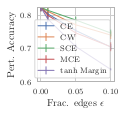

In [132]:
plt.gcf()

# Datasets

In [44]:
def value_to_storage(val: float, decimals: int = 2):
    if val / 1e3 < 1:
        return f'{val:.{decimals}f} B'
    if val / 1e6 < 1:
        return f'{val / 1e3:.{decimals}f} kB'
    if val / 1e9 < 1:
        return f'{val / 1e6:.{decimals}f} MB'
    if val / 1e12 < 1:
        return f'{val / 1e9:.{decimals}f} GB'
    if val / 1e15 < 1:
        return f'{val / 1e12:.{decimals}f} TB'
    if val / 1e18 < 1:
        return f'{val / 1e15:.{decimals}f} PB'
    raise ValueError(f'{val} is too big for Peta!!!')

In [45]:
from ogb.nodeproppred import PygNodePropPredDataset

from rgnn_at_scale.data import load_dataset

dataset_df = []
for dataset in tqdm.tqdm(['cora_ml', 'citeseer', 'pubmed', 'ogbn-arxiv', 'ogbn-products', 'ogbn-papers100M']):
    if dataset.startswith('ogbn'):
        pyg_dataset = PygNodePropPredDataset(root='/nfs/staff-ssd/geisler/dontrobme/datasets', name=dataset)
        nnodes = pyg_dataset[0].x.shape[0]
        nedges = pyg_dataset[0].edge_index.shape[1]
        nfeatures = pyg_dataset[0].x.shape[1]
    else:
        graph = load_dataset(dataset, '/nfs/staff-ssd/geisler/dontrobme/datasets').standardize(
            make_unweighted=True,
            make_undirected=True,
            no_self_loops=True,
            select_lcc=True
        )
        #graph = load_and_standardize(dataset)
        nnodes = graph.adj_matrix.shape[0]
        nedges = graph.adj_matrix.nnz
        nfeatures = graph.attr_matrix.shape[1]
    dataset_df.append({
            r'\textbf{Dataset}': dataset_map[dataset].replace(r'rotatebox{90}', r'textbf'),
            r'\textbf{\#Nodes $n$}': f'{nnodes:,}',
            r'\textbf{\#Edges $e$}': f'{nedges:,}',
            r'\textbf{\#Features $d$}': f'{nfeatures:,}',
            #r'\textbf{\#Possible edges}': f'{nnodes ** 2:.3E}',
            r'\textbf{Size (dense)}': value_to_storage(4 * nnodes ** 2),
            r'\textbf{Size (sparse)}': value_to_storage(2*8*nedges + 4*nedges),
        })
dataset_df = pd.DataFrame(dataset_df).set_index(r'\textbf{Dataset}')
dataset_df

 83%|████████▎ | 5/6 [00:37<00:07,  7.49s/it]


KeyboardInterrupt: 

In [ ]:
dataset_df.to_dict()

In [ ]:
print(dataset_df
    #.sort_index()
    .to_latex(
        float_format='%.2f',
        caption='Statistics of the used datasets. For the dense adjacency matrix we assume that each elements is represented by 4 bytes. In the sparse case we use two 8 byte integer pointers and a 4 bytes float value.', 
        label='tab:datasets',
        escape=False
    )
)

# PPR

In [ ]:
def ppr(A):
    A_norm = A / A.sum(-1)[:, None]
    return alpha * torch.inverse(torch.eye(4) + (alpha - 1) * A_norm)

def update(A_dense, ppr_original, u, v):
    i = torch.nonzero(u.flatten()).item()
    
    row = A_dense[i] + v
    row = row / row.sum()
    A_norm = A_dense[i] / A_dense[i].sum()
    row_diff = row - A_norm
    row_diff_norm = (alpha - 1) * row_diff
    print(row_diff_norm)

    P_inv = (1 / alpha) * ppr_original
    P_uv_inv = P_inv - (P_inv @ u @ row_diff_norm @ P_inv) / (1 + row_diff_norm @ P_inv @ u)
    ppr_update = alpha * P_uv_inv
    
    return ppr_update

alpha = 0.15
A_dense_list = [
    torch.tensor([[0, 1, 0, 1],
                  [1, 0, 1, 0],
                  [0, 0, 0, 1],
                  [1, 1, 1, 0]],
                 dtype=torch.float32),    
    torch.tensor([[0, 1, 0, 1],
                  [1, 0, 1, 0],
                  [0, 1, 0, 1],
                  [1, 1, 1, 0]],
                 dtype=torch.float32),
    torch.tensor([[0, 1, 0, 1],
                  [1, 0, 1, 0],
                  [0, 0, 0, 1],
                  [1, 1, 1, 0]],
                 dtype=torch.float32),    
    torch.tensor([[0, 1, 0, 1],
                  [1, 0, 1, 0],
                  [0, 1, 0, 1],
                  [1, 1, 1, 0]],
                 dtype=torch.float32)
]


u_list = [
    torch.tensor([[0], [0], [1], [0]], dtype=torch.float32),
    torch.tensor([[0], [0], [1], [0]], dtype=torch.float32),
    torch.tensor([[1], [0], [0], [0]], dtype=torch.float32),
    torch.tensor([[0], [1], [0], [0]], dtype=torch.float32),
    torch.tensor([[0], [0], [0], [1]], dtype=torch.float32)
]
v_list = [
    torch.tensor([[0.3, 0.1, 0, 0.3]], dtype=torch.float32, requires_grad=True),
    torch.tensor([[0.3, 0.1, 0, 0.3]], dtype=torch.float32, requires_grad=True),
    torch.tensor([[0.3, 0.1, 12, 0.3]], dtype=torch.float32, requires_grad=True),
    torch.tensor([[0.3, 0.1, 0.8, 0.3]], dtype=torch.float32, requires_grad=True),
    torch.tensor([[0.3, 0.1, 0.8, 0.3]], dtype=torch.float32, requires_grad=True)
]


for A_dense, u, v in zip(A_dense_list, u_list, v_list):

    ppr_original = ppr(A_dense)
    print(ppr_original)

    A_pert = A_dense + u@v
    print(A_pert)

    ppr_target = ppr(A_dense + u@v)
    print('Soll', ppr_target)

    ppr_update = update(A_dense, ppr_original, u, v)
    print('Ist', ppr_update)

    ppr_update.sum().backward()
    print(v.grad)

    assert torch.allclose(ppr_update, ppr_target)

In [ ]:
for A_dense, u, v in zip(A_dense_list, u_list, v_list):

    ppr_original = ppr(A_dense)
    print(ppr_original)

    A_pert = A_dense + u@v
    print(A_pert)

    ppr_target = ppr(A_dense + u@v)
    print('Soll', ppr_target)

    ppr_update = update(A_dense, ppr_original, u, v)
    print('Ist', ppr_update)

    ppr_update.sum().backward()
    print(v.grad)

    assert torch.allclose(ppr_update, ppr_target)